# Instability Analysis for Moving Barrier Cosntraint
It has been observed that moving barrier constraint has worse stability in general. In this notebook, we will see why it happens.

## Experiment details
In our algorithm, as a part of the Douglas-Rachford algorithm, we project our variables to the costraint space. To do this, we solve the following equation:
$\begin{align} U - U_0 + I^* (I(U)- V_0) + H^* \lambda = 0\end{align}$
where $U,V$ are the projected variables to be found, $U_0, V_0$ are the original variables, $I$ is the interpolation operator, $H$ represents the operator defining the affine constraint $HU = F$ and $\lambda$ is a Largrange multiplier to be found.

In this experiment, we will plot the norm of the LHS of (1) and $\lambda$. When we calculate $\lambda$, we find $HU'- F = H(\textrm{Id}+  I^* I)^{-1}(U + I^* V) - F$ and solve a certain linear equation with $HU'-F$ as the right hand side. We call this vector a `pre_lambda` vector. We will also plot the norm of  this vector as well as the norm of $U' = (\textrm{Id}+  I^* I)^{-1}(U + I^* V)$.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('../../..')
from proximal.dynamicUOT import computeGeodesic
from proximal.grids import speed_and_growth
import ipywidgets as widgets
from ipywidgets import interact
from collections import defaultdict
from PIL import Image

## Plotting function

In [2]:
def plot_log(log):
    # Plot 'pre_lambda', 'lambda', and 'first_order_condition' using subplots with different colors
    fig, axs = plt.subplots(6, 1, figsize=(10, 18))
    
    axs[0].plot(log['U_prime_interp'], label='U_prime_interp', color='blue')
    axs[0].set_xlabel('Iteration')
    axs[0].set_ylabel('Value')
    axs[0].set_title('Plot of U_prime_interp')
    axs[0].legend()

    # Plot 'pre_lambda'
    axs[1].plot(log['pre_lambda'], label='pre_lambda', color='blue')
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Value')
    axs[1].set_title('Plot of pre_lambda')
    axs[1].legend()
    
    # Plot 'lambda'
    axs[2].semilogy(log['lambda'], label='lambda', color='green')
    axs[2].set_xlabel('Iteration')
    axs[2].set_ylabel('Value')
    axs[2].set_title('Plot of lambda')
    axs[2].legend()
    
    # Plot 'first_order_condition'
    axs[3].semilogy(log['first_order_condition'], label='first_order_condition', color='red')
    axs[3].set_xlabel('Iteration')
    axs[3].set_ylabel('Value')
    axs[3].set_title('Plot of first_order_condition')
    axs[3].legend()

    # Plot 'HQHlambda'
    axs[4].plot(log['HQHlambda'], label='HQHlambda', color='red')
    axs[4].set_xlabel('Iteration')
    axs[4].set_ylabel('Value')
    axs[4].set_title('Plot of HQHlambda')
    axs[4].legend()

    # Plot 'lambda_eqn'
    axs[5].plot(log['lambda_eqn'], label='lambda_eqn', color='red')
    axs[5].set_xlabel('Iteration')
    axs[5].set_ylabel('Value')
    axs[5].set_title('Plot of lambda_eqn')
    axs[5].legend()
    
    plt.show()

# Unconstrained case
In the unconstrained case, we do not calculate the quantities mentioned above, but we still calculate $U' = (\textrm{Id}+  I^* I)^{-1}(U + I^* V)$. We will plot the norm of this quantity here.

## Set up

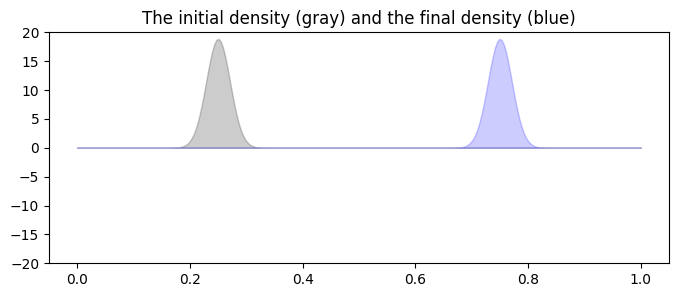

In [3]:
# Plotting initial and the final density
sigma = 0.03
K = 256
X = np.linspace(0, 1, K)  # Discretization of the time-space domain

def gauss(x, x_0, sigma, mass):
    # Gaussian bump
    normalized_factor = np.exp(-((x - x_0) ** 2) / sigma ** 2)
    return mass * (normalized_factor * K / np.sum(normalized_factor))

rho_0 = gauss(X, 0.25, sigma, 1) # Initial density
rho_1 = gauss(X, 0.75, sigma, 1)  # Final density

# Normalizing densities
rho_0 /= np.sum(rho_0) / 256 # make sure the total mass is 1
rho_1 /= np.sum(rho_1) / 256

rho_0.dtype = np.float64
rho_1.dtype = np.float64

# Plotting
plt.figure(figsize=(8, 3))
plt.ylim(-20, 20)
plt.title("The initial density (gray) and the final density (blue)")
plt.fill_between(X, rho_0, color="k", alpha=0.2)  # Use fill_between for similar effect to fill in Julia
plt.fill_between(X, rho_1, color="b", alpha=0.2)
plt.show()

## Calculation

In [4]:
T = 15 # number of time steps
ll = (1.0, 1.0) # size of time x space box
H = np.ones((T,K))
delta = 0.5/np.pi
log = defaultdict(list)
x, lists = computeGeodesic(rho_0, rho_1, T, ll, p= 2.0, q=2.0, delta=delta, niter=3000, log=log)

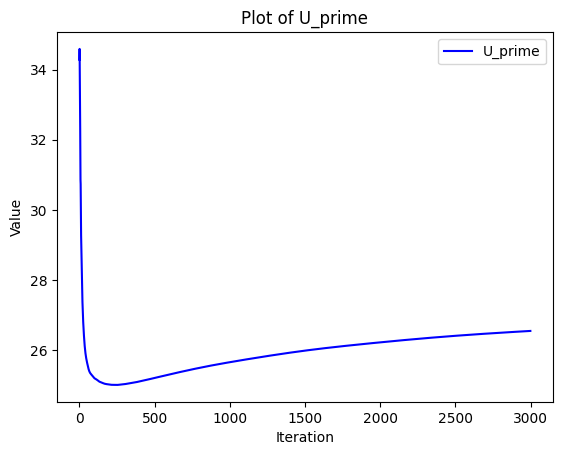

In [5]:
plt.plot(log['U_prime_interp'], label='U_prime', color='blue')
plt.xlabel('Iteration')
plt.ylabel('Value')
plt.title('Plot of U_prime')
plt.legend()
plt.show()

# Total mass constraint
We will first see the plot for total mass constraint, which is known to be stable for comparison.

## Set up

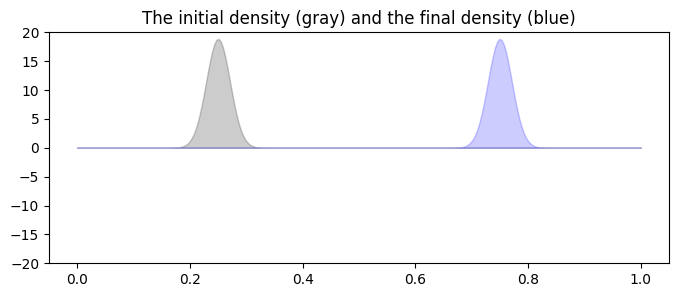

In [6]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('../../..')
from proximal.dynamicUOT import computeGeodesic
from proximal.grids import speed_and_growth
import ipywidgets as widgets
from ipywidgets import interact
from collections import defaultdict
from PIL import Image

# Plotting initial and the final density
sigma = 0.03
K = 256
X = np.linspace(0, 1, K)  # Discretization of the time-space domain

def gauss(x, x_0, sigma, mass):
    # Gaussian bump
    normalized_factor = np.exp(-((x - x_0) ** 2) / sigma ** 2)
    return mass * (normalized_factor * K / np.sum(normalized_factor))

rho_0 = gauss(X, 0.25, sigma, 1) # Initial density
rho_1 = gauss(X, 0.75, sigma, 1)  # Final density

# Normalizing densities
rho_0 /= np.sum(rho_0) / 256 # make sure the total mass is 1
rho_1 /= np.sum(rho_1) / 256

rho_0.dtype = np.float64
rho_1.dtype = np.float64

# Plotting
plt.figure(figsize=(8, 3))
plt.ylim(-20, 20)
plt.title("The initial density (gray) and the final density (blue)")
plt.fill_between(X, rho_0, color="k", alpha=0.2)  # Use fill_between for similar effect to fill in Julia
plt.fill_between(X, rho_1, color="b", alpha=0.2)
plt.show()

## Calculation

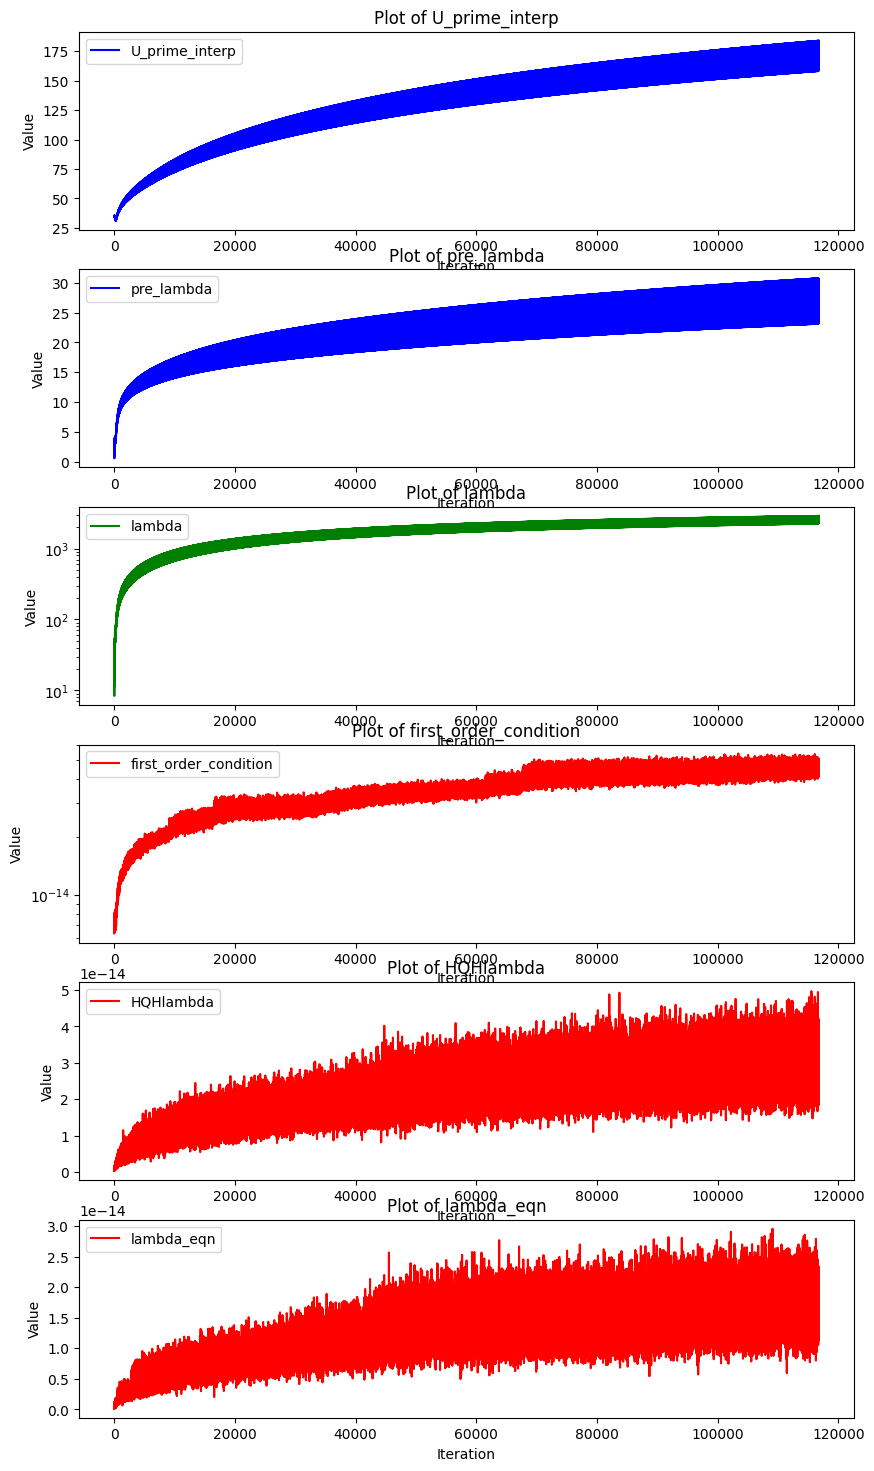

In [7]:
T = 15 # number of time steps
ll = (1.0, 1.0) # size of time x space box
H = np.ones((T,K))
time = np.array([(i+0.5)/T for i in range(0,T)])
F = np.ones(T)
log = defaultdict(list)
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p= 2.0, q=2.0, delta=0.5/np.pi, niter=3000, log=log)
plot_log(log)

# Stationary Barrier Constraint
For another reference, we will plot the same graph for stationary barrier constraint.

## Set up

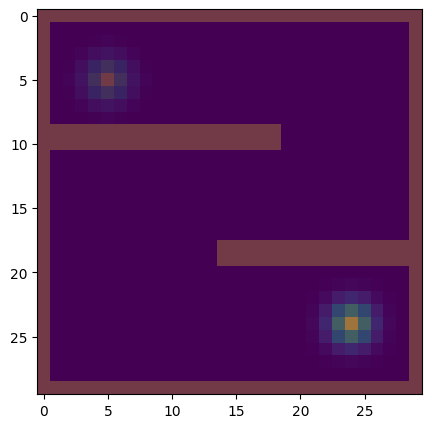

In [8]:
def image_to_numpy(image_path):
    # Load the image file
    image = Image.open(image_path).convert('L')  # Convert image to grayscale if it's not

    # Convert the PIL image to a numpy array
    image_array = np.array(image)

    return image_array

maze = (1-image_to_numpy('data/input/maze.png').squeeze()/255)

T = 60
N1 = maze.shape[0]
N2 = maze.shape[1]

H = np.repeat(maze[np.newaxis, :, :], T, axis=0)
F = np.zeros((T,))

dx = [1./N1, 1./N2]

indices = np.arange(0, 30) * 1./30
xx, yy = np.meshgrid(indices, indices)

rho_0 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[5./30., 5./30.], cov=2./36**2)
rho_1 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[24./30., 24./30.], cov=2./36**2)

plt.figure(figsize=(5, 5))
plt.imshow(maze)
plt.imshow(rho_0, alpha=0.5)
plt.imshow(rho_1, alpha=0.5)
plt.show()  

## Calculation

In [9]:
ll=(1.0, 1.0, 1.0)
log = defaultdict(list)
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p= 2.0, q=2.0, delta=1.0, niter=7000, log=log)

KeyboardInterrupt: 

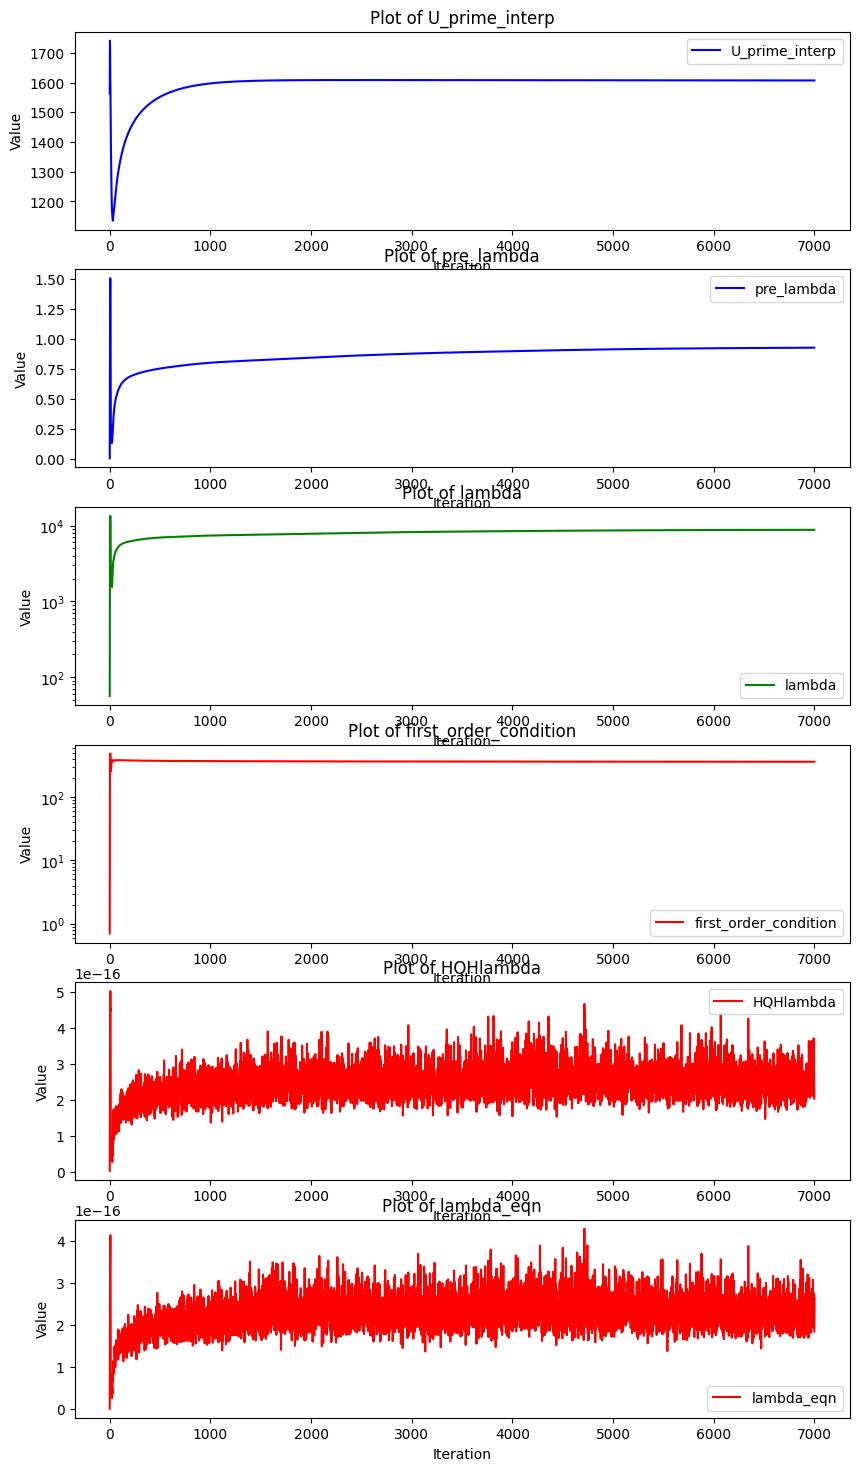

In [ ]:
plot_log(log)

## One Stationary One Moving
We will now consider a moving barrier constraint. 

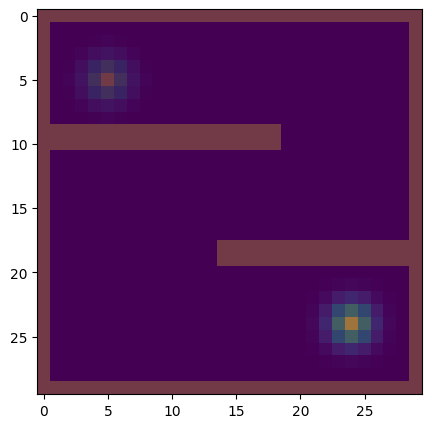

In [ ]:
def image_to_numpy(image_path):
    # Load the image file
    image = Image.open(image_path).convert('L')  # Convert image to grayscale if it's not

    # Convert the PIL image to a numpy array
    image_array = np.array(image)

    return image_array

maze = (1-image_to_numpy('data/input/maze.png').squeeze()/255)

T = 30
N1 = maze.shape[0]
N2 = maze.shape[1]

H = np.repeat(maze[np.newaxis, :, :], T, axis=0)
F = np.zeros((T,))

dx = [1./N1, 1./N2]

indices = np.arange(0, 30) * 1./30
xx, yy = np.meshgrid(indices, indices)

rho_0 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[5./30., 5./30.], cov=2./36**2)
rho_1 = sp.stats.multivariate_normal.pdf(np.stack([xx, yy], axis=-1), mean=[24./30., 24./30.], cov=2./36**2)

plt.figure(figsize=(5, 5))
plt.imshow(maze)
plt.imshow(rho_0, alpha=0.5)
plt.imshow(rho_1, alpha=0.5)
plt.show()

def fill_region(frames, fps, speed, original, Hstep):
    rows, cols = 30, 30
    step_size = speed*14/fps

    # Define the region to fill
    start_col, end_col = 1, 14

    # Create a list to store each frame
    filled_frames = [original]

    for i in range(1,frames):
        frame = filled_frames[-1].copy()
        # Determine the slice to fill based on speed
        end_fill = max(1, int(end_col - i*step_size))
        frame[18:20, end_fill:14] += Hstep
        # if above 1, clip to 1
        frame[frame > 1] = 1
        
        # Append the current state of the array to the list
        filled_frames.append(frame.copy())
    
    return filled_frames

def plot_frames(frames):
    fig, axes = plt.subplots(1, len(frames), figsize=(15, 5))
    for idx, frame in enumerate(frames):
        ax = axes[idx]
        ax.imshow(frame, cmap='viridis', vmin=0, vmax=1)
        ax.axis('off')
        ax.set_title(f'Frame {idx + 1}')
    plt.tight_layout()
    plt.show()

### Unstable case
As observed in One Stationary One Moving experiment, if the "step size" of the wall is too large, the solution diverges. We will see what happens when the divergence happens.

In [ ]:
frames = fill_region(T, 30, 1.0, maze, Hstep=1.0)
H = np.stack(frames, axis=0)
ll=(1.0, 1.0, 1.0)
log = defaultdict(list)
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p= 2.0, q=2.0, delta=1.0, niter=3000, log=log)

Norm of H_sum: 1076.2620498744718
Norm of IQ_plus_Q: 1.864031177051844
(1.0, 1.0, 1.0) (30, 30, 30)
Multiplier: 1.234567901234568e-06
Norm of Q[0]: 8.492643875731515
Norm of HQH: 0.00045219977052403723
Condition number of HQH: 203.43329008852342
HQHlambda - pre_lambda: [ 8.31395311e-07 -1.41000251e-07  8.22501465e-07 -1.35398251e-07
  7.89159417e-07 -1.29794710e-07  7.56499011e-07 -1.24304013e-07
  7.24496881e-07 -1.18791027e-07  6.92364845e-07 -1.08734457e-07
  6.33750856e-07  6.09230657e-08 -3.55085649e-07  2.06959083e-06
 -3.03563911e-07  1.76930013e-06 -2.53061999e-07  1.47495342e-06
 -2.03548550e-07  1.18636789e-06 -1.54947363e-07  9.03099416e-07
 -1.05608841e-07  6.15533434e-07 -1.62630326e-19 -5.42101086e-20
  0.00000000e+00  0.00000000e+00]
Norm of HQHlambda - pre_lambda: 4.076613762919634e-06
HQHlambda - pre_lambda: [-2.17540989e-04  5.23007418e-05 -3.05087660e-04  5.35347944e-05
 -3.12023875e-04  5.01604444e-05 -2.92356495e-04  4.54653389e-05
 -2.64991414e-04  4.04736682e-05 

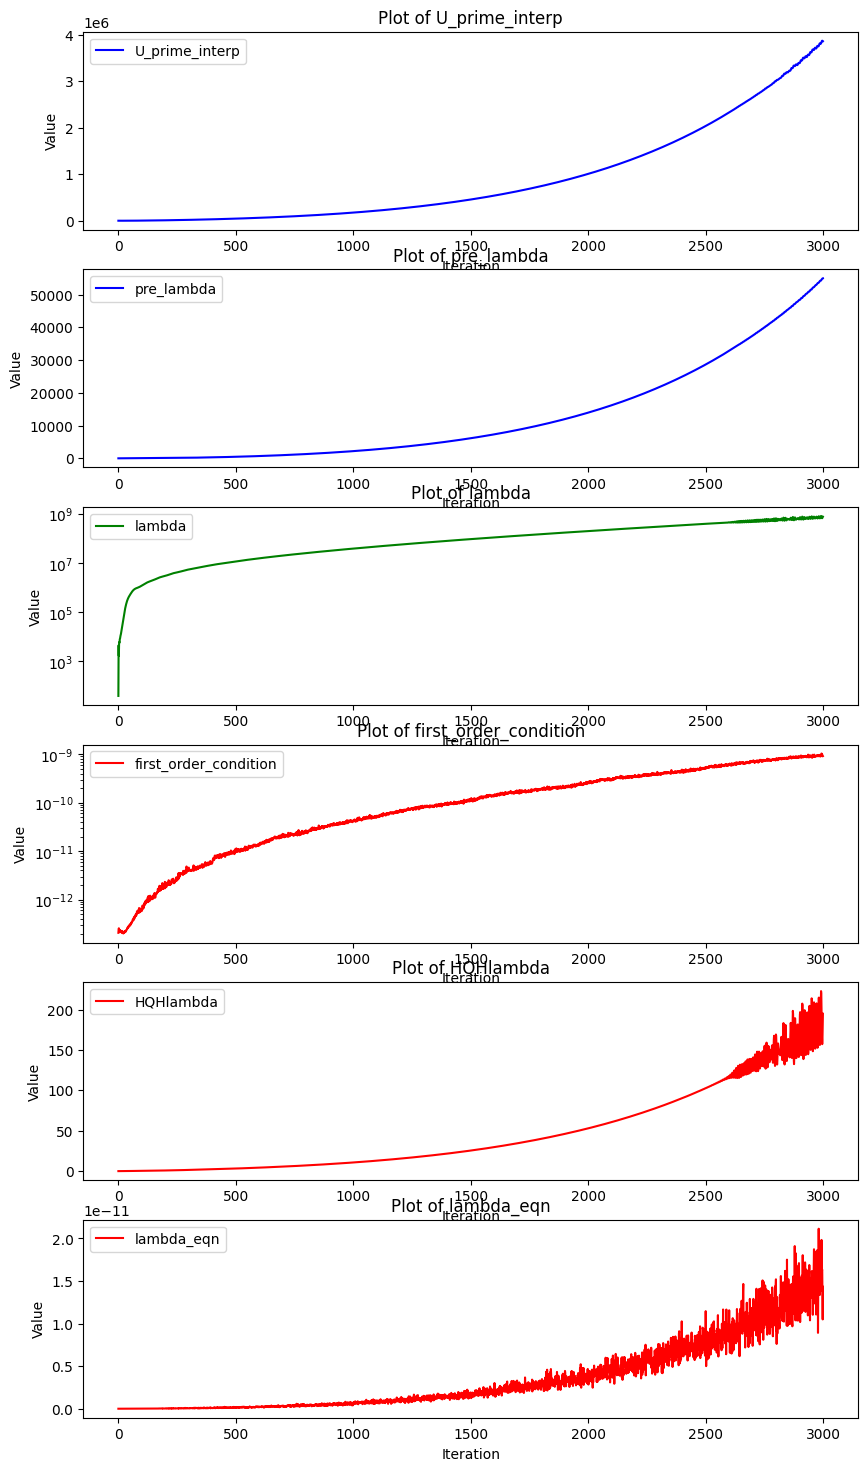

In [ ]:
plot_log(log)

### Stable Case
It has been observed that the solution is relatively stable when `Hstep` is small. We will see what happens in this case.

In [ ]:
frames = fill_region(T, 30, 1.0, maze, Hstep=0.05)
H = np.stack(frames, axis=0)
ll=(1.0, 1.0, 1.0)
log = defaultdict(list)
x, lists = computeGeodesic(rho_0, rho_1, T, ll, H, F, p= 2.0, q=2.0, delta=10.0, niter=3000, log=log)

Norm of H_sum: 1025.5380936854565
Norm of IQ_plus_Q: 1.864031177051844
(1.0, 0.1, 0.1) (30, 30, 30)
Multiplier: 1.2345679012345684e-10
Norm of Q[0]: 8.492643875731515
Norm of HQH: 4.308661373666451e-08
Condition number of HQH: 202.2506164194086
HQHlambda - pre_lambda: [-3.44826606e-09  2.23048853e-08 -9.56218322e-09  3.98565988e-08
 -1.36626592e-08  5.23669410e-08 -1.56905879e-08  5.97652702e-08
 -1.56352647e-08  6.19999573e-08 -1.35007740e-08  5.90538657e-08
 -9.31014402e-09  5.09454406e-08 -2.99135791e-09  3.26764122e-08
  6.62403556e-09  1.60284889e-08  1.52037067e-08 -1.35309600e-09
  7.38440744e-09 -1.21468649e-08  1.09456147e-08 -2.47097282e-08
  1.47974010e-08 -3.71706101e-08  1.87752288e-08 -5.02202952e-08
  2.16260263e-08 -6.27015379e-08]
Norm of HQHlambda - pre_lambda: 1.754819858978045e-07
HQHlambda - pre_lambda: [-1.97707188e-06  1.91608362e-06 -4.85956252e-06  2.89740742e-06
 -6.15688620e-06  2.36517326e-06 -5.78462626e-06  2.74067007e-07
 -3.79347382e-06 -3.43104826e-06 -

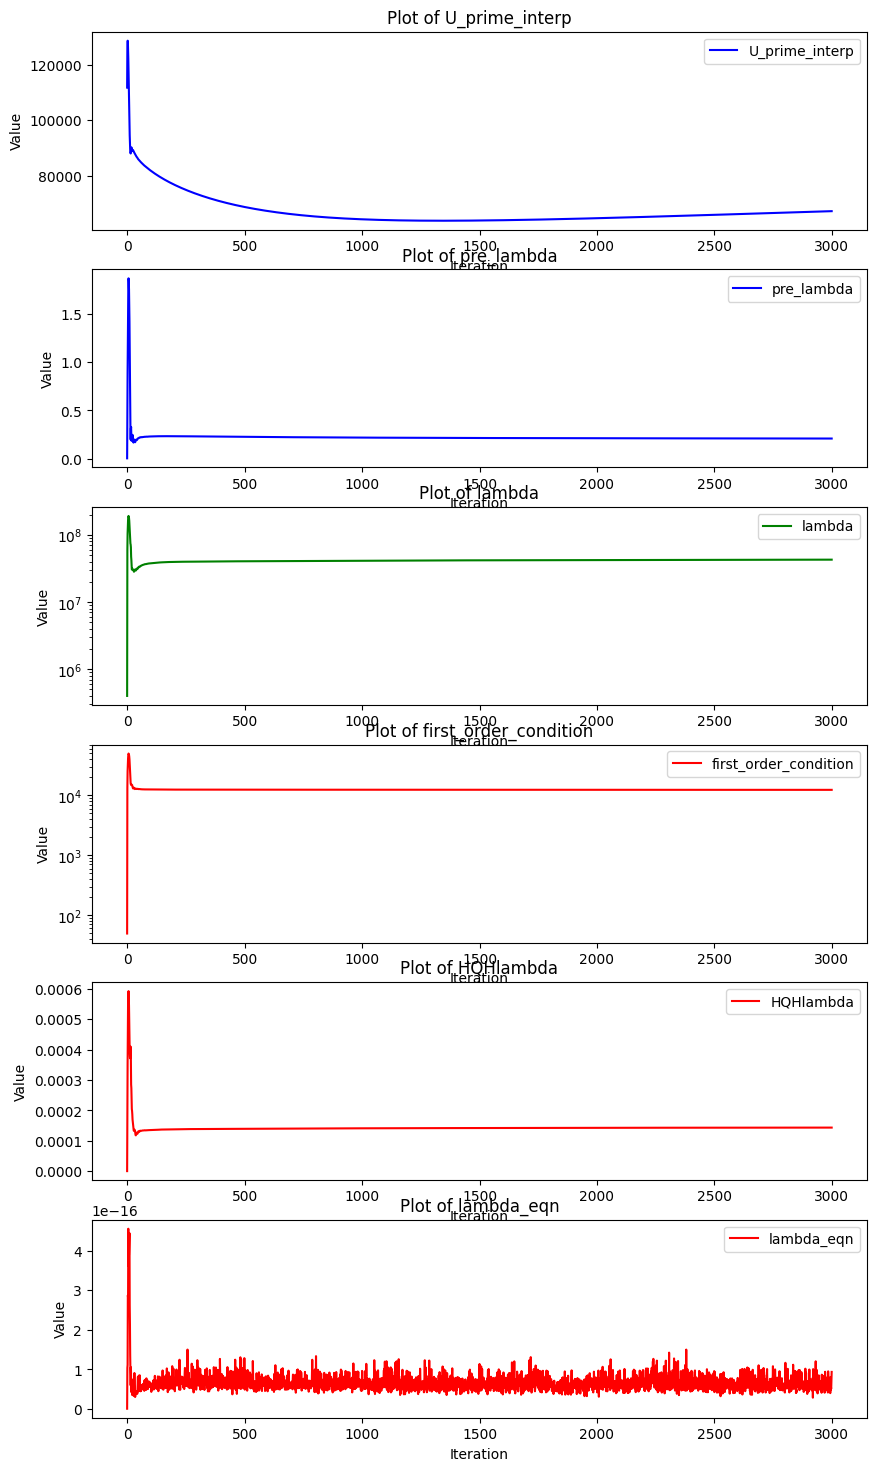

In [ ]:
plot_log(log)